In [1]:
# !pip install tensorflow
# !pip install tflearn
# !pip install tqdm

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance
from random import shuffle
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [3]:
MASK_PATH_TRAIN = "Face Mask Dataset/Train/WithMask"
WITHOUT_MASK_PATH_TRAIN = "Face Mask Dataset/Train/WithoutMask"
MASK_PATH_TEST = "Face Mask Dataset/Test/WithMask"
WITHOUT_MASK_PATH_TEST = "Face Mask Dataset/Test/WithoutMask"
MASK_PATH_VALID = "Face Mask Dataset/Validation/WithMask"
WITHOUT_MASK_PATH_VALID = "Face Mask Dataset/Validation/WithoutMask"

In [4]:
def get_image_set(path, target):
    image_set = []
    target_set = []
    for i in os.listdir(path):
        pic = os.path.join(path+"/",i)
        image_set.append(pic)
        target_set.append(target)
    return image_set, target_set

In [6]:
encoder = LabelEncoder()

In [9]:
train_image_mask, train_target_mask = get_image_set(MASK_PATH_TRAIN, "mask")
image_no_mask, target_no_mask = get_image_set(WITHOUT_MASK_PATH_TRAIN, "without_mask")
mask = pd.DataFrame()
mask["image"] = train_image_mask
mask["target"] = train_target_mask
without_mask = pd.DataFrame()
without_mask["image"] = image_no_mask
without_mask["target"] = target_no_mask
train_data = pd.concat([mask, without_mask], axis=0,ignore_index=True)
train_data = train_data.sample(frac=1)
train_data

,image,target
4950,Face Mask Dataset/Train/WithMask/Augmented_90_...,mask
1628,Face Mask Dataset/Train/WithMask/Augmented_265...,mask
793,Face Mask Dataset/Train/WithMask/Augmented_109...,mask
6163,Face Mask Dataset/Train/WithoutMask/2257.png,without_mask
588,Face Mask Dataset/Train/WithMask/641.png,mask
...,...,...
4780,Face Mask Dataset/Train/WithMask/Augmented_864...,mask
1709,Face Mask Dataset/Train/WithMask/Augmented_280...,mask
4039,Face Mask Dataset/Train/WithMask/Augmented_720...,mask
9254,Face Mask Dataset/Train/WithoutMask/560.png,without_mask


In [38]:
test_image_mask, test_target_mask = get_image_set(MASK_PATH_TEST, "mask")
test_image_no_mask, test_target_no_mask = get_image_set(WITHOUT_MASK_PATH_TEST,"without_mask")
mask = pd.DataFrame()
mask["image"] = test_image_mask
mask["target"] = test_target_mask
without_mask = pd.DataFrame()
without_mask["image"] = test_image_no_mask
without_mask["target"] = test_target_no_mask
test_data = pd.concat([mask, without_mask], axis=0,ignore_index=True)
test_data = test_data.sample(frac=1)
test_data

,image,target
449,Face Mask Dataset/Test/WithMask/Augmented_82_1...,mask
577,Face Mask Dataset/Test/WithoutMask/2051.png,without_mask
376,Face Mask Dataset/Test/WithMask/Augmented_686_...,mask
25,Face Mask Dataset/Test/WithMask/1767.png,mask
324,Face Mask Dataset/Test/WithMask/Augmented_56_3...,mask
...,...,...
915,Face Mask Dataset/Test/WithoutMask/5675.png,without_mask
432,Face Mask Dataset/Test/WithMask/Augmented_796_...,mask
388,Face Mask Dataset/Test/WithMask/Augmented_707_...,mask
456,Face Mask Dataset/Test/WithMask/Augmented_844_...,mask


In [39]:
valid_image_mask, valid_target_mask = get_image_set(MASK_PATH_VALID, "mask")
valid_image_no_mask, valid_target_no_mask = get_image_set(WITHOUT_MASK_PATH_VALID,"without_mask")
mask = pd.DataFrame()
mask["image"] = valid_image_mask
mask["target"] = valid_target_mask
without_mask = pd.DataFrame()
without_mask["image"] = valid_image_no_mask
without_mask["target"] = valid_target_no_mask
valid_data = pd.concat([mask, without_mask], axis=0,ignore_index=True)
valid_data = valid_data.sample(frac=1)
valid_data

,image,target
116,Face Mask Dataset/Validation/WithMask/Augmente...,mask
307,Face Mask Dataset/Validation/WithMask/Augmente...,mask
199,Face Mask Dataset/Validation/WithMask/Augmente...,mask
653,Face Mask Dataset/Validation/WithoutMask/4397.png,without_mask
156,Face Mask Dataset/Validation/WithMask/Augmente...,mask
...,...,...
704,Face Mask Dataset/Validation/WithoutMask/5106.png,without_mask
550,Face Mask Dataset/Validation/WithoutMask/3007.png,without_mask
422,Face Mask Dataset/Validation/WithoutMask/1374.png,without_mask
520,Face Mask Dataset/Validation/WithoutMask/2536.png,without_mask


In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input


vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(128,128,3))
for layer in vgg19.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [45]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          fill_mode="nearest"
                                         )
train_generator = train_data_generator.flow_from_dataframe(dataframe=train_data,
                                                          x_col= "image",
                                                          y_col = "target",
                                                          target_size = (150,150),
                                                          batch_size = 32,
                                                          class_mode = "binary")
test_generator = train_data_generator.flow_from_dataframe(dataframe=test_data,
                                                          x_col= "image",
                                                          y_col = "target",
                                                          target_size = (150,150),
                                                          batch_size = 32,
                                                          class_mode = "binary")
valid_generator = train_data_generator.flow_from_dataframe(dataframe=valid_data,
                                                          x_col= "image",
                                                          y_col = "target",
                                                          target_size = (150,150),
                                                          batch_size = 32,
                                                          class_mode = "binary")

Found 5466 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [54]:
model.compile(loss = 'binary_crossentropy',
             optimizer= optimizers.RMSprop(lr=1e-3),
             metrics = ["acc"])

In [56]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator)//32)

Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 0.3798 - acc: 0.8438
Epoch 2/50
5/5 [==============================] - 8s 1s/step - loss: 0.2893 - acc: 0.9125
Epoch 3/50
5/5 [==============================] - 8s 1s/step - loss: 0.2335 - acc: 0.9125
Epoch 4/50
5/5 [==============================] - 8s 1s/step - loss: 0.2126 - acc: 0.9312
Epoch 5/50
5/5 [==============================] - 8s 1s/step - loss: 0.2018 - acc: 0.9250
Epoch 6/50
5/5 [==============================] - 8s 1s/step - loss: 0.2641 - acc: 0.9062
Epoch 7/50
5/5 [==============================] - 8s 1s/step - loss: 0.2023 - acc: 0.9312
Epoch 8/50
5/5 [==============================] - 8s 1s/step - loss: 0.1938 - acc: 0.9250
Epoch 9/50
5/5 [==============================] - 7s 1s/step - loss: 0.1428 - acc: 0.9438
Epoch 10/50
5/5 [==============================] - 8s 1s/step - loss: 0.1677 - acc: 0.9500
Epoch 11/50
5/5 [==============================] - 7s 1s/step - loss: 0.1388 - acc: 0.9563
Epoch 1

In [60]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


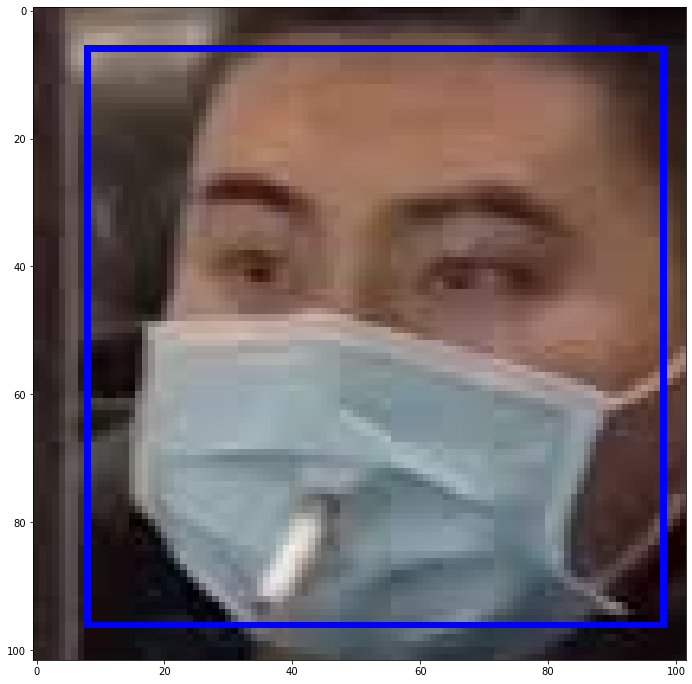

In [67]:
face_model = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
img = cv2.imread('Face Mask Dataset/Train/WithMask/1058.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [69]:
sample_mask_img = cv2.imread('Face Mask Dataset/Train/WithMask/1058.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0
model.predict(sample_mask_img)

array([[0.03515759]], dtype=float32)

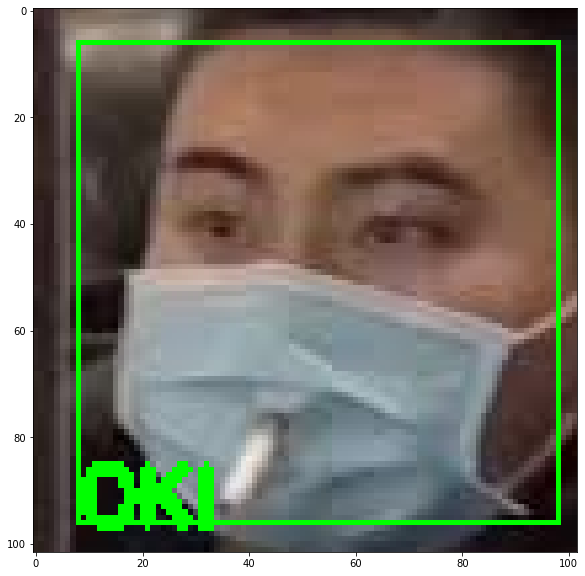

In [71]:
mask_label = {0:'OK!',1:'Busted'}
dist_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y+90), cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No face!")